## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch
# !pip install torch torchvision torchaudio

# # Install additional dependencies
# !pip install pandas pillow

# # Install ONNX packages
# !pip install onnx onnxruntime onnx-simplifier

# # Install OpenVINO
# !pip install openvino

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
import json
from pathlib import Path
import random

# Import utility functions
from cjm_psl_utils.core import download_file
from cjm_pil_utils.core import resize_img

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Import PIL for image manipulation
from PIL import Image, ImageDraw, ImageFont

# Import PyTorch dependencies
import torch

# Import Keypoint R-CNN
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor

# Import ONNX dependencies
import onnx # Import the onnx module
from onnxsim import simplify # Import the method to simplify ONNX models
import onnxruntime as ort # Import the ONNX Runtime

## Setting Up the Project

### Set the Directory Paths

In [3]:
# The name for the project
project_name = f"pytorch-keypoint-r-cnn"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# The path to the checkpoint folder
checkpoint_dir = Path(project_dir/f"2024-01-30_10-44-52")

pd.Series({
    "Project Directory:": project_dir,
    "Checkpoint Directory:": checkpoint_dir,
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-keypoint-r-cnn
Checkpoint Directory:,pytorch-keypoint-r-cnn/2024-01-30_10-44-52


### Download a Font File

In [4]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


## Loading the Checkpoint Data

### Load the Colormap

In [5]:
# The colormap path
colormap_path = list(checkpoint_dir.glob('*colormap.json'))[0]

# Load the JSON colormap data
with open(colormap_path, 'r') as file:
        colormap_json = json.load(file)

# Convert the JSON data to a dictionary        
colormap_dict = {item['label']: item['color'] for item in colormap_json['items']}

# Extract the class names from the colormap
class_names = list(colormap_dict.keys())

# Make a copy of the colormap in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colormap_dict.values()]

### Load the Model Checkpoint

In [6]:
# The model checkpoint path
checkpoint_path = list(checkpoint_dir.glob('*.pth'))[0]

# Load the model checkpoint onto the CPU
model_checkpoint = torch.load(checkpoint_path, map_location='cpu')

### Load the Trained Keypoint R-CNN Model

In [7]:
# Load a pre-trained model
model = keypointrcnn_resnet50_fpn(weights='DEFAULT')

# Replace the classifier head with the number of keypoints
in_features = model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels
model.roi_heads.keypoint_predictor = KeypointRCNNPredictor(in_channels=in_features, num_keypoints=len(class_names))

# Initialize the model with the checkpoint parameters and buffers
model.load_state_dict(model_checkpoint)

<All keys matched successfully>

## Exporting the Model to ONNX

In [8]:
model.eval();

### Prepare the Input Tensor

In [9]:
input_tensor = torch.randn(1, 3, 256, 256)

### Export the Model to ONNX

In [10]:
# Set a filename for the ONNX model
onnx_file_path = f"{checkpoint_dir}/{colormap_path.stem.removesuffix('-colormap')}-{checkpoint_path.stem}.onnx"

# Export the PyTorch model to ONNX format
torch.onnx.export(model.cpu(),
                  input_tensor.cpu(),
                  onnx_file_path,
                  export_params=True,
                  do_constant_folding=False,
                  input_names = ['input'],
                  output_names = ['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'],
                  dynamic_axes={'input': {2 : 'height', 3 : 'width'}}
                 )

/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/torch/nn/functional.py:3964: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/torchvision/ops/boxes.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/torchvision/ops/boxes.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

### Simplify the ONNX Model

In [11]:
# Load the ONNX model from the onnx_file_name
onnx_model = onnx.load(onnx_file_path)

# Simplify the model
model_simp, check = simplify(onnx_model)

# Save the simplified model to the onnx_file_name
onnx.save(model_simp, onnx_file_path)

## Performing Inference with ONNX Runtime

### Create an Inference Session

In [12]:
# Load the model and create an InferenceSession
session = ort.InferenceSession(onnx_file_path, providers=['CPUExecutionProvider'])

2024-01-30 11:51:30.456289089 [W:onnxruntime:, graph.cc:3553 CleanUnusedInitializersAndNodeArgs] Removing initializer '2802'. It is not used by any node and should be removed from the model.
2024-01-30 11:51:30.456303937 [W:onnxruntime:, graph.cc:3553 CleanUnusedInitializersAndNodeArgs] Removing initializer '2806'. It is not used by any node and should be removed from the model.
2024-01-30 11:51:30.456311275 [W:onnxruntime:, graph.cc:3553 CleanUnusedInitializersAndNodeArgs] Removing initializer '3372'. It is not used by any node and should be removed from the model.
2024-01-30 11:51:30.456312978 [W:onnxruntime:, graph.cc:3553 CleanUnusedInitializersAndNodeArgs] Removing initializer '3368'. It is not used by any node and should be removed from the model.
2024-01-30 11:51:30.456340313 [W:onnxruntime:, graph.cc:3553 CleanUnusedInitializersAndNodeArgs] Removing initializer '3763'. It is not used by any node and should be removed from the model.
2024-01-30 11:51:30.456342277 [W:onnxruntime:

### Define Annotation Function

In [13]:
def draw_keypoints_pil(image, keypoints, labels, colors, radius:int=5):

    """
    Annotates an image with keypoints, each marked by a circle and associated with specific labels and colors.

    This function draws circles on the provided image at given keypoint coordinates. Each keypoint is associated 
    with a label and a color. The radius of the circles can be adjusted.

    Parameters:
    image (PIL.Image): The input image on which annotations will be drawn.
    keypoints (list of tuples): A list of (x, y) tuples representing the coordinates of each keypoint.
    labels (list of str): A list of labels corresponding to each keypoint.
    colors (list of tuples): A list of RGB tuples for each keypoint, defining the color of the circle to be drawn.
    radius (int, optional): The radius of the circles to be drawn for each keypoint. Defaults to 5.

    Returns:
    annotated_image (PIL.Image): The image annotated with keypoints, each represented as a colored circle.
    """
        
    # Create a copy of the image
    annotated_image = image.copy()

    # Create an ImageDraw object for drawing on the image
    draw = ImageDraw.Draw(annotated_image)

    # Loop through the bounding boxes and labels in the 'annotation' DataFrame
    for i in range(len(labels)):
        # Get the key point coordinates
        x, y = keypoints[i]

        # Draw a circle
        draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=colors[i])
        
    return annotated_image

### Select a Test Image

The file ./pexels-2769554-man-doing-rock-and-roll-sign.jpg already exists and overwrite is set to False.


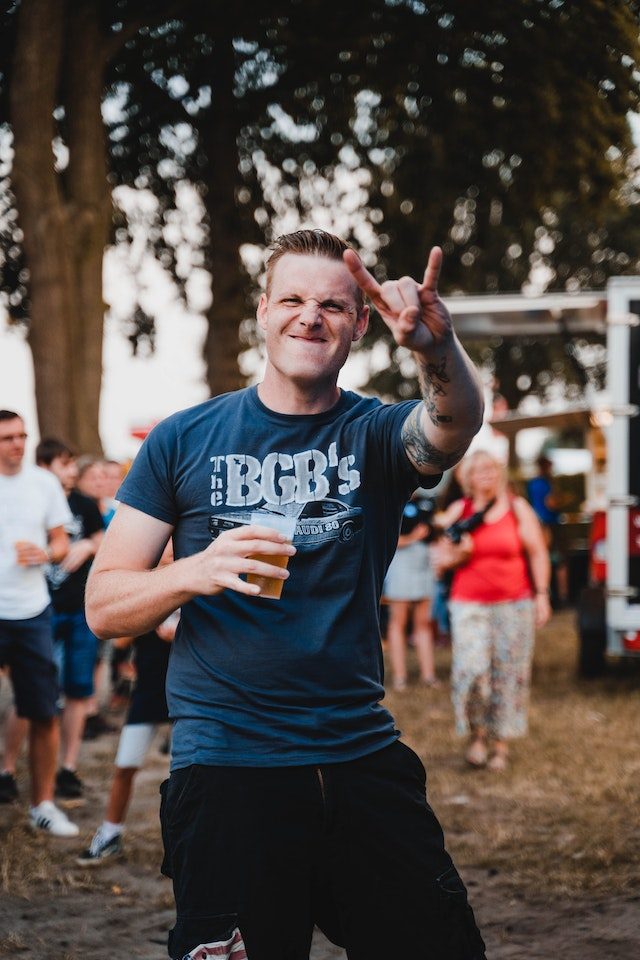

Test Image Size:,"(640, 960)"


In [14]:
test_img_name = "pexels-2769554-man-doing-rock-and-roll-sign.jpg"
test_img_url = f"https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/{test_img_name}"

download_file(test_img_url, './', False)

test_img = Image.open(test_img_name)
display(test_img)

pd.Series({
    "Test Image Size:": test_img.size, 
}).to_frame().style.hide(axis='columns')

### Prepare the Test Image

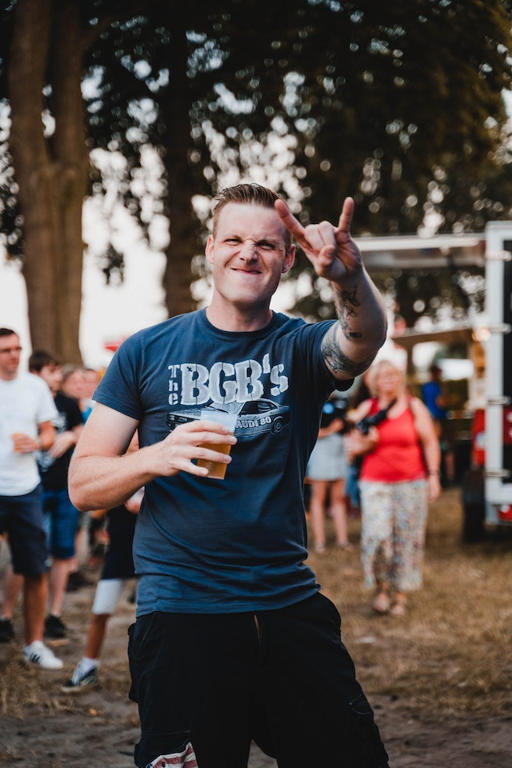

Source Image Size:,"(640, 960)"
Input Dims:,"(512, 768)"
Min Image Scale:,1.250000
Input Image Size:,"(512, 768)"


In [15]:
# Set test image size
test_sz = 512

## Resize the test image
input_img = resize_img(test_img, target_sz=test_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

display(input_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

### Prepare the Input Tensor

In [16]:
# Convert the input image to NumPy format
input_tensor_np = np.array(input_img, dtype=np.float32).transpose((2, 0, 1))[None]/255

### Compute the Predictions

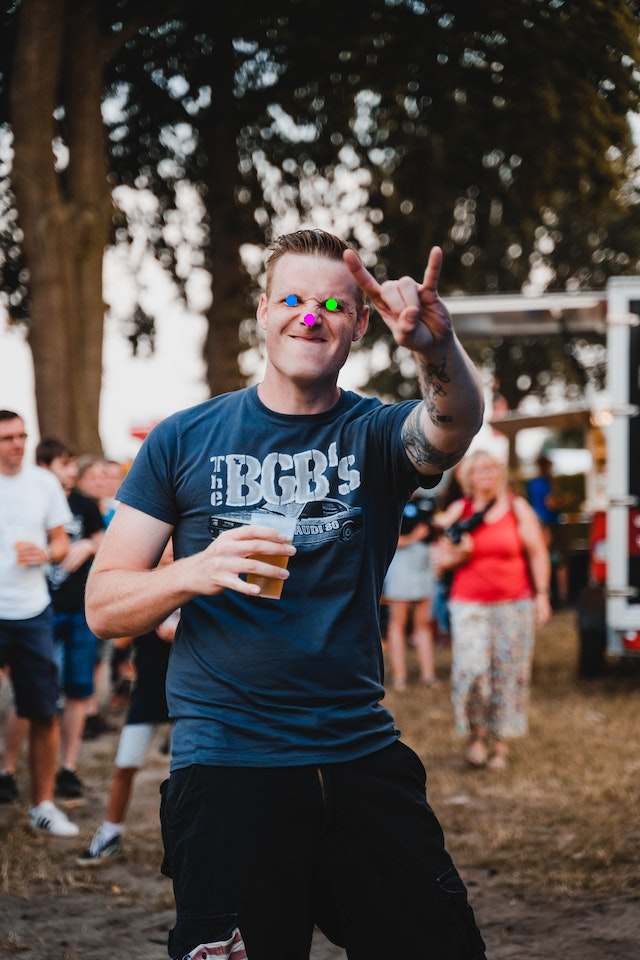

In [17]:
# Run inference
model_output = session.run(None, {"input": input_tensor_np})

# Set the confidence threshold
conf_threshold = 0.8

# Filter the output based on the confidence threshold
scores_mask = model_output[2] > conf_threshold

# Extract and scale the predicted keypoints
predicted_keypoints = (model_output[3][scores_mask])[:,:,:-1].reshape(-1,2)*min_img_scale
predicted_keypoints

labels=class_names*sum(scores_mask).item()

draw_keypoints_pil(test_img, 
                predicted_keypoints, 
                labels=labels,
                colors=[int_colors[i] for i in [class_names.index(label) for label in labels]],
               )